# Análisis exploratorio: Corona virus (Covid-19)

## Hito 1
Somos el equipo conformado por Raúl Cid, José Espina, Michelle Valenzuela y Alejandro Veragua. Nuestro *dataset* corresponde al [publicado en el portal Kaggle](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset) construido y mantenido por la Universidad John Hopkins

Escogimos ese *dataset* frente al importante histórico momento que vive la humanidad. No ha habido precedentes de lo que está sucediendo y nos es de sumo interés el comprender cómo es el comportamiento del virus en el tiempo y el intento de buscar patrones en su contagia a nivel poblacional

Durante el semestre, nos gustaría poder responder a las siguientes preguntas


* P1) ¿Cuáles son los países más afectado, y que región?
* P2) ¿Cuántos contagiados, fallecidos, y recuperados por día tiene cada país?
* P3) ¿Cómo establecer una métrica comparativa para los afectados en cada país?
* P4) ¿Cómo comparar el comportamiento del virus en los distintos paises a través del tiempo?
* P5) ¿Cómo caracterizar la tasa de contagio?
* P6) ¿Cómo se correlacionan los confirmados con los recuperados y fallecidos?
* P7) ¿Pueden indicar los datos una relacion de causa-consecuencia con las medidas sanitarias tomadas?
* P8) ¿Las medidas adoptadas por los gobiernos y entidades de salud logran disminuir significativamente el número de afectados por el virus, tales como cierre de aeropuerto, centros comerciales y cuarentenas? ¿Se podrá caracterizar qué medidas adoptadas por el Gobierno y entidades de salud han ayudado a mitigar el número de contagiados, a nivel regional y nacional?
* P9) ¿Qué organismos están involucrados en tomar medidas sanitarias?
* P10) ¿Qué medidas sanitarias han adoptado estos organismos?
* P11) ¿Cuándo se tomaron estas medidas?
* P12) ¿Es posible estimar, con estos datos, cuando se podrá controlar la propagación el virus?
* P13) ¿Cuáles son los intervalos de tiempo en que los afectados se recuperan o fallecen?
## Metodología de exploración
Buscaremos responder las preguntas a través de la siguiente estrategia.

* 1 Análisis exploratorio de los datos. Correspondiente a la entrega del hito 1. Se realizará lo siguiente:
* 1.1 Para cada archivo CSV del *dataset*, describir cada una de sus columnas
* 1.2 Contar datos NaNs (Not a Number) y vacíos por cada columna
* 1.3 Calcular estadísticas básicas, tales como mínimos, máximos, medias, desviación estándar y otros
* 1.4 Un país afectado es aquel en el que pocos se han recuperado y/o muchos han fallecido. Y encontrar el top 10 de estas relaciones
* 2 Analizar las diferencias para cada columna por día
* 3 Se propone calcular la aceleración de contagiados, fallecidos y recuperados, para cada país, dado un intervalo de tiempo. Estas medidas pretenden ser un estandar para comparar distintos paises
* 4 Análisis de autocorrelacion multivariado, por tiempo.
* 5 Análisis de peaks de autocorrelación.
* 6 Requerirá cruce con otros *dataset* de medidas adoptadas por los gobiernos, como por ejemplo, [restricción de movimiento por país](https://data.humdata.org/dataset/country-point-of-entry-mobility-restriction-covid-19-iom-dtm?force_layout=desktop)
* 7 Análisis de prensa local e internacional, para las medidas sanitarias
* 8 Uso de técnicas de machine learning para suavización, estimación, predicción sobre los datos
## Configuración base del notebook
El bloque a continuación configura el libro, definiendo funciones y cargando las fuentes de datos

In [46]:
# Librería de álgebra lineal
import numpy as np 
# Procesamiento de datos y carga de archivos CSV
import pandas as pd
# Librearía gráfica
import matplotlib.pylab as plt
# Librería para usar recursos del sistema operativo
import os 
# Librearía usada para extraer el nombre del archivo de cada path
import ntpath
# Librería gráfica
import seaborn as sns
# Librearía para usar herramientas relacionadas con
# aprendizaje máquina. Se usó para preprocesar y
# calcular regresión
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
# Colores
from matplotlib import colors

# Configuración general
%load_ext autoreload
%autoreload 2

# Funciones definidas por nosotros
def calcularEstadisticos(dataFrame):
    total = len(dataFrame)
    print('------------ NULOS ------------')
    nulos = dataFrame.isna().sum()
    print(nulos)
    print('------------ MINIMOS ------------')
    minimos = dataFrame.min()
    print(minimos)
    print('------------ MAXIMOS ------------')
    maximos = dataFrame.max()
    print(maximos)
    print('------------ PROMEDIOS ------------')
    promedios = dataFrame[['Confirmed', 'Deaths', 'Recovered']].mean()
    print(promedios)
    print('------------ STD ------------')
    std = dataFrame[['Confirmed', 'Deaths', 'Recovered']].std()
    print(std)

# Se prepara carga de los archivos del dataset
paths = []
for dirname, _, filenames in os.walk('./novel-corona-virus-2019-dataset'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        paths.append(path);
dataFrames = {}
for path in paths:
    dataFrames[ntpath.basename(path)] = pd.read_csv(path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# I Análisis Exploratorio
## Observaciones por simple inspección
* El dataset está compuesto por 8 archivos CSV, que contienen registros por país y región del número de infectados, recuperados y fallecidos
* El archivo */kaggle/input/novel-corona-virus-2019-dataset/COVID19_open_line_list.csv* tiene las columnas vacias al final 
* El archivo */kaggle/input/novel-corona-virus-2019-dataset/COVID19_line_list_data.csv* tiene la cuarta columa vacía, y las del final

## Análisis del archivo *covid_19_data.csv*

Este archivo describe la cantidad de afectados por el virus para casos confirmados, fallecimientos y recuperados, de forma acumulativa
### Vista preliminar

In [75]:
covid19Data = dataFrames['covid_19_data.csv']
covid19Data.head(2)

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0


### Descripción de las columnas
* ObservationDate: Corresponde a la fecha en que se tomó el dato
* Province/State: Corresponde al nombre de la provincia o región del país donde se tomó el dato
* Country/Region: Corresponde al nombre del país donde se tomó el dato
* Last Update: Corresponde a la fecha en que actualizó el dato por última vez
* Confirmed: Corresponde a la cantidad acumulada de personas contagiadas del virus confirmadas hasta la fecha
* Deaths: Corresponde a la cantidad acumulada de personas fallecidas por el virus confirmadas hasta la fecha
* Recovered: Corresponde a la cantidad acumulada de personas recuperadas del virus hasta la fecha
### Cálculo de estadísticas básicas

In [48]:
calcularEstadisticos(covid19Data)

------------ NULOS ------------
SNo                   0
ObservationDate       0
Province/State     5486
Country/Region        0
Last Update           0
Confirmed             0
Deaths                0
Recovered             0
dtype: int64
------------ MINIMOS ------------
SNo                              1
ObservationDate         01/22/2020
Country/Region          Azerbaijan
Last Update        1/22/2020 17:00
Confirmed                        0
Deaths                           0
Recovered                        0
dtype: object
------------ MAXIMOS ------------
SNo                                         11614
ObservationDate                        04/03/2020
Country/Region     occupied Palestinian territory
Last Update                           3/8/20 5:31
Confirmed                                  119827
Deaths                                      14681
Recovered                                   63612
dtype: object
------------ PROMEDIOS ------------
Confirmed    1175.025831
Deaths     

### Tabla resumen de las estadísticas básicas
| Nombre columna  | Filas   | Nulos | Tipo de dato | Mínimo   | Máximo   |
|-----------------|---------|-------|--------------|----------|----------|
| ObservationDate |  9423   |  0    |    Fecha     |01/22/2020|03/27/2020|
| Province/State  |  9423   | 4260  |    Texto     |NO APLICA |NO APLICA |
| Country/Region  |  9423   |   0   |    Texto     |NO APLICA |NO APLICA |
| Last Update     |  9423   |   0   |    Fecha     |1/22/2020 | 3/8/20   |
| Confirmed       |  9423   |   0   |    Número    |    0     |   86498  |
| Deaths          |  9423   |   0   |    Número    |    0     |   9134   |
| Recovered       |  9423   |   0   |    Número    |    0     |  61732   |

# Archivo *time_series_covid_19_confirmed.csv*
Este archivo describe los casos confirmados en el tiempo, por país
### Vista preliminar

In [76]:
casosConfirmados = dataFrames['time_series_covid_19_confirmed.csv']
casosConfirmados.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,84,94,110,110,120,170,174,237,273,281
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,146,174,186,197,212,223,243,259,277,304


### Descripción de las columnas
* Province/State: Corresponde al nombre de la provincia o región del país donde se tomó el dato
* Country/Region: Corresponde al nombre del país donde se tomó el dato
* Lat: Latitud (georreferencia) de la región. En caso de ser NaN, corresponderá a la del país donde se tomó el dato
* Long: Longitud (georreferencia) de la región. En caso de ser NaN, corresponderá a la del país donde se tomó el dato
* <Mes/Día/Año>: Cantidad de casos confirmados el día indicado en el nombre de la columna por región y país
### Cálculo de estadísticas básicas

In [50]:
print(casosConfirmados.isna().sum().head())
print("----")
print(len(casosConfirmados))
print("----")
print(casosConfirmados.min().head())
print("----")
print(casosConfirmados.max().head())

Province/State    178
Country/Region      0
Lat                 0
Long                0
1/22/20             0
dtype: int64
----
258
----
Country/Region    Afghanistan
Lat                  -41.4545
Long                     -135
1/22/20                     0
1/23/20                     0
dtype: object
----
Country/Region    Zimbabwe
Lat                71.7069
Long               178.065
1/22/20                444
1/23/20                444
dtype: object


### Tabla resumen de las estadísticas básicas
| Nombre columna  | Filas   | Nulos | Tipo de dato | Mínimo   | Máximo   |
|-----------------|---------|-------|--------------|----------|----------|
| Province/State |  258     | 178   |   Texto      |          |          |
| Country/Region | 258      | 0     |   Texto      |Afghanistan|Zimbabwe |
| Lat            | 258      | 0     |   Número     |-41.4545  |71.7069   |
| Long           | 258      | 0     |   Número     |-135      |178.065   |
| <Mes/Día/Año>  | 258      | 0     |   Número     | NA       |  NA      |

# Archivo *time_series_covid_19_recovered.csv*
Este archivo describe los casos recuperados en el tiempo
### Vista preliminar

In [77]:
casosRecuperados = dataFrames['time_series_covid_19_recovered.csv']
casosRecuperados.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,2,2,2,2,2,2,5,5,10,10
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,17,17,31,31,33,44,52,67,76,89


### Descripción de las columnas
* Province/State: Corresponde al nombre de la provincia o región del país donde se tomó el dato
* Country/Region: Corresponde al nombre del país donde se tomó el dato
* Lat: Latitud (georreferencia) de la región. En caso de ser NaN, corresponderá a la del país donde se tomó el dato
* Long: Longitud (georreferencia) de la región. En caso de ser NaN, corresponderá a la del país donde se tomó el dato
* <Mes/Día/Año>: Cantidad de casos confirmados el día indicado en el nombre de la columna por región y país
### Cálculo de estadísticas básicas

In [52]:
print(casosRecuperados.isna().sum().head())
print("----")
print(len(casosRecuperados))
print("----")
print(casosRecuperados.min().head())
print("----")
print(casosRecuperados.max().head())

Province/State    179
Country/Region      0
Lat                 0
Long                0
1/22/20             0
dtype: int64
----
244
----
Country/Region    Afghanistan
Lat                  -41.4545
Long                 -106.347
1/22/20                     0
1/23/20                     0
dtype: object
----
Country/Region    Zimbabwe
Lat                71.7069
Long               178.065
1/22/20                 28
1/23/20                 28
dtype: object


### Tabla resumen de las estadísticas básicas
| Nombre columna  | Filas   | Nulos | Tipo de dato | Mínimo   | Máximo   |
|-----------------|---------|-------|--------------|----------|----------|
| Province/State |  244     | 179   |   Text       |          |          |
| Country/Region | 244      | 0     |   Text       |Afghanistan|Zimbabwe |
| Lat            | 244      | 0     |   Number     |-41.4545  |71.7069   |
| Long           | 244      | 0     |   Number     |-106.347  |178.065   |
| <Mes/Día/Año>  | 244      | 0     |   Number     | NA       |  NA      |

# Archivo *time_series_covid_19_deaths.csv*
Este archivo describe los casos de muerte en el tiempo, por país y región

In [78]:
casosFallecidos=dataFrames['time_series_covid_19_deaths.csv']
casosFallecidos.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,2,4,4,4,4,4,4,4,6,6
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,5,6,8,10,10,11,15,15,16,17


### Descripción de las columnas
* Province/State: Corresponde al nombre de la provincia o región del país donde se tomó el dato
* Country/Region: Corresponde al nombre del país donde se tomó el dato
* Lat: Latitud (georreferencia) de la región. En caso de ser NaN, corresponderá a la del país donde se tomó el dato
* Long: Longitud (georreferencia) de la región. En caso de ser NaN, corresponderá a la del país donde se tomó el dato
* <Mes/Día/Año>: Cantidad de casos confirmados el día indicado en el nombre de la columna por región y país
### Cálculo de estadísticas básicas

In [54]:
print(casosFallecidos.isna().sum().head())
print("----")
print(len(casosFallecidos))
print("----")
print(casosFallecidos.min().head())
print("----")
print(casosFallecidos.max().head())

Province/State    178
Country/Region      0
Lat                 0
Long                0
1/22/20             0
dtype: int64
----
258
----
Country/Region    Afghanistan
Lat                  -41.4545
Long                     -135
1/22/20                     0
1/23/20                     0
dtype: object
----
Country/Region    Zimbabwe
Lat                71.7069
Long               178.065
1/22/20                 17
1/23/20                 17
dtype: object


### Tabla resumen de las estadísticas básicas
| Nombre columna  | Filas   | Nulos | Tipo de dato | Mínimo   | Máximo   |
|-----------------|---------|-------|--------------|----------|----------|
| Province/State |  258     | 179   |   Text       |          |          |
| Country/Region | 258      | 0     |   Text       |Afghanistan|Zimbabwe |
| Lat            | 258      | 0     |   Number     |-41.4545  |71.7069   |
| Long           | 258      | 0     |   Number     |-135      |178.065   |
| <Mes/Día/Año>  | 258      | 0     |   Number     | NA       |  NA      |

# Archivo *COVID19_open_line_list*
Datos personales, de ubicación y síntomas de personas contagiadas

In [79]:
casosPorPersona = dataFrames['COVID19_open_line_list.csv']
casosPorPersona.head(2)

,ID,age,sex,city,province,country,wuhan(0)_not_wuhan(1),latitude,longitude,geo_resolution,...,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44
0,1.0,30,male,"Chaohu City, Hefei City",Anhui,China,1.0,31.64696,117.7166,admin3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,47,male,"Baohe District, Hefei City",Anhui,China,1.0,31.77863,117.3319,admin3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
casosPorPersona.columns

Index(['ID', 'age', 'sex', 'city', 'province', 'country',
       'wuhan(0)_not_wuhan(1)', 'latitude', 'longitude', 'geo_resolution',
       'date_onset_symptoms', 'date_admission_hospital', 'date_confirmation',
       'symptoms', 'lives_in_Wuhan', 'travel_history_dates',
       'travel_history_location', 'reported_market_exposure',
       'additional_information', 'chronic_disease_binary', 'chronic_disease',
       'source', 'sequence_available', 'outcome', 'date_death_or_discharge',
       'notes_for_discussion', 'location', 'admin3', 'admin2', 'admin1',
       'country_new', 'admin_id', 'data_moderator_initials', 'Unnamed: 33',
       'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37',
       'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41',
       'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44'],
      dtype='object')

### Descripción de las columnas
* ID: Identificador único del registro
* age: Edad de la persona contagiada
* sex: Sexo de la persona contagiada
* city: Ciudad del domicilio de la persona contagiada
* province: Provincia o región del país de origen de la persona contagiada
* wuhan_not_wuhan: Dato binario que indica si la persona estuvo en la ciudad china de Wuhan
* latitude: Latitud (georreferencia) de la región o país del domicilio de la persona
* longitude: Longitud (georreferencia) de la región o país del domicilio de la persona
* geo_resolution: Por definir
* date_onset_symptoms: Síntomas de la persona al momento de presentarse en el hospital
* date_admission_hospital: Fecha de ingreso al hospital
* date_confirmation: Fecha de confirmación de la infección
* symptoms: Síntomas de la persona
* lives_in_Wuhan: Indica si vive en la ciudad china de Wuhan
* travel_history_dates: Fecha de su último viaje
* travel_history_location: Lugar de su úlitmo viaje
* reported_market_exposure: Indica si estuvo expuesto al mercado de mariscos de la ciudad china de Wuhan
* additional_information: Información adicional
* chronic_disease_binary: Indica si la persona sufre de alguna enfermedad crónica
* chronic_disease: Indica el nombre de la enfermedad crónica de la persona, si es que la padece
* source: Fuente del registro
* sequence_available: Indicador de secuencia
* outcome: Indica el estado final de la persona contagiada
* date_death_or_discharge: Fecha de muerte o de alta de la persona contagiada
* notes_for_discussion: Apuntes adicionales
* location: Ubicación de la persona
* admin3: Ciudad donde se administra el caso
* admin2: Ciudad donde se administra el caso
* admin1: Ciudad donde se administra el caso
* country_new: País de origen de la persona infectada
* admin_id: Identificador de uso interno
* data_moderator_initials: Iniciales del responsable del dato
### Cálculo de estadísticas básicas

In [57]:
print(casosPorPersona.isna().sum().head())
print("----")
print(len(casosPorPersona))
print("----")
print(casosPorPersona.min())
print("----")
print(casosPorPersona.max())

ID            953
age         12777
sex         12862
city         3932
province     1220
dtype: int64
----
14126
----
ID                          1.00000
wuhan(0)_not_wuhan(1)       1.00000
latitude                  -37.81360
longitude                -124.95307
chronic_disease_binary      0.00000
Unnamed: 33                     NaN
Unnamed: 34                     NaN
Unnamed: 35                     NaN
Unnamed: 36                     NaN
Unnamed: 37                     NaN
Unnamed: 38                     NaN
Unnamed: 39                     NaN
Unnamed: 40                     NaN
Unnamed: 41                     NaN
Unnamed: 42                     NaN
Unnamed: 43                     NaN
Unnamed: 44                     NaN
dtype: float64
----
ID                        13479.000000
wuhan(0)_not_wuhan(1)         1.000000
latitude                     69.649468
longitude                   153.400000
chronic_disease_binary        1.000000
Unnamed: 33                        NaN
Unnamed: 34    

### Tabla resumen de las estadísticas básicas
| Nombre columna  | Filas   | Nulos | Tipo de dato | Mínimo   | Máximo   |
|-----------------|---------|-------|--------------|----------|----------|
| ID              |  14126  |   953 |   Numero     |   1      |  13479   |
| age             |  14126  |  12777|   Numero     |          |          |
| sex             |  14126  |  12862|   Numero     |          |          |
| city            |  14126  |  3932 |   Numero     |          |          |
| province        |  14126  |  1220 |   Numero     |          |          |
| wuhan_not_wuhan |  14126  |  0    |  Número[0,1] |   0      |    1     |
| latitude        |  14126  |  0    | Número       | -37.81360| 69.649468|
| longitude       |  14126  |  0    | Número       | -124.95307| 153.4 |
| chronic_disease_binary|14126|0    | Número       | 0        | 1      |

**Nota** Es importante observar que la cantidad de nulos es no menor. Esto puede sesgar los datos e invalidar los posibles análisis

# Archivo *COVID19_line_list_data.csv*
Datos personales de personas infectados de fuentes privadas

In [81]:
casosPorPersona2=dataFrames['COVID19_line_list_data.csv']
casosPorPersona2.head(2)

,id,case_in_country,reporting date,Unnamed: 3,summary,location,country,gender,age,symptom_onset,...,recovered,symptom,source,link,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,1,NaN,1/20/2020,NaN,First confirmed imported COVID-19 pneumonia pa...,"Shenzhen, Guangdong",China,male,66.0,01/03/20,...,0,NaN,Shenzhen Municipal Health Commission,http://wjw.sz.gov.cn/wzx/202001/t20200120_1898...,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,1/20/2020,NaN,First confirmed imported COVID-19 pneumonia pa...,Shanghai,China,female,56.0,1/15/2020,...,0,NaN,Official Weibo of Shanghai Municipal Health Co...,https://www.weibo.com/2372649470/IqogQhgfa?fro...,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
casosPorPersona2.columns

Index(['id', 'case_in_country', 'reporting date', 'Unnamed: 3', 'summary',
       'location', 'country', 'gender', 'age', 'symptom_onset',
       'If_onset_approximated', 'hosp_visit_date', 'exposure_start',
       'exposure_end', 'visiting Wuhan', 'from Wuhan', 'death', 'recovered',
       'symptom', 'source', 'link', 'Unnamed: 21', 'Unnamed: 22',
       'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26'],
      dtype='object')

### Descripción de las columnas
* id: Identificador único del registro de la persona contagiada
* case_in_country: El número de caso en el país al que pertenece la persona contagiada
* reporting date: Fecha en que se reporta el caso
* summary: Resumen del caso
* location: Ciudad o país donde se reporta el caso
* country: País en que se reporta el caso
* gender: Sexo de la persona infectada. Los valores posibles son "male" o "female"
* age: Edad de la persona contagiada
* symptom_onset: Síntomas al momento de llegar al hospital
* If_onset_approximated: Valor binario. Indica si la hora de la visita al hospital es aproximada
* hosp_visit_date: Fecha en que la persona se presentó en el hospital
* exposure_start: Indica la fecha de inicio en que la persona se expuso al virus
* exposure_end: Indica la fecha en que la persona dejó de estar expuesta al virus
* visiting Wuhan: Indica la persona estuvo en la ciudad china de Wuhan
* from Wuhan: Valor binario. Indica si la persona vive en la ciudad china de Wuhan
* death: Indica la fecha de muerte de la persona
* recovered: Indica la fecha de recuperación de la persona
* symptom: Síntomas de la persona al ser diagnosticada con el virus
* source: Fuente del caso
* link: Sitio web de la fuente del caso
### Cálculo de estadísticas básicas

In [61]:
print(casosPorPersona2.isna().sum().head())
print("----")
print(len(casosPorPersona2))
print("----")
print(casosPorPersona2.min())
print("----")
print(casosPorPersona2.max())

id                    0
case_in_country     197
reporting date        1
Unnamed: 3         1085
summary               5
dtype: int64
----
1085
----
id                                                                       1
case_in_country                                                          1
Unnamed: 3                                                             NaN
location                                                       Afghanistan
country                                                        Afghanistan
age                                                                   0.25
If_onset_approximated                                                    0
visiting Wuhan                                                           0
from Wuhan                                                               0
death                                                                    0
recovered                                                                0
source                     

### Tabla resumen de las estadísticas básicas
| Nombre columna  | Filas   | Nulos | Tipo de dato | Mínimo   | Máximo   |
|-----------------|---------|-------|--------------|----------|----------|
| id              |  1085   |   0   |   Numero     |   1      |  1085    |
| case_in_country | 1085    | 197   | Número       |  1       | 1443     |
| reporting date  |  1085   |   1   | Fecha        |          |          |
| summary         |  1085   | 5     | Texto        |          |          |
| location        |  1085   |  0    |  Texto       |Afghanistan|Zhuhai   |
| country         |  1085   |  0    |  Texto       |Afghanistan|Vietnam  |
|age              |  1085   |  0    |  Número      |  0.25     |  96     |
|If_onset_approximated|  1085|  0   |  Número      |     0     |   1     |
|visiting Wuhan   |  1085   |  0    |  Número      |     0     |   1     |
|from Wuhan       |  1085   |  0    |  Número      |     0     |   1     |

# Análisis exploratorio por países de interés
Nuestro primer criterio de exploración es ver los países que han aparecido en la prensa por sus alarmantes cifras, tales como Estados Unidos, España, Italia, Ecuador, Brasil, China, y también nuestro país
A continuación, un análsis descriptivo simple a través de gráficos para visualizar la cantidad de confirmados, recuperados y fallecidos por día

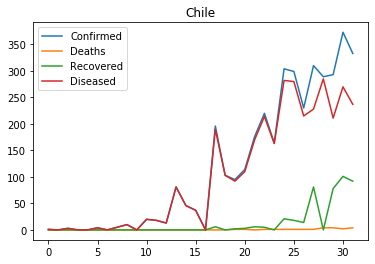

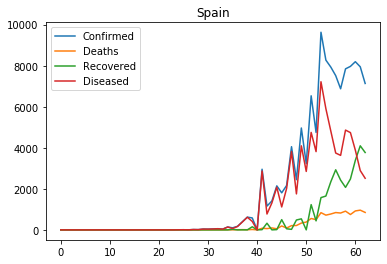

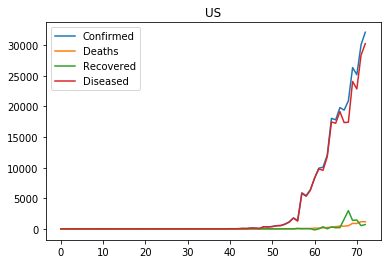

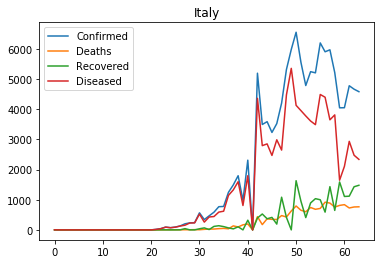

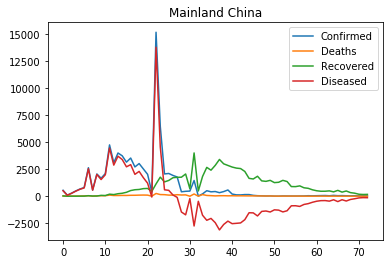

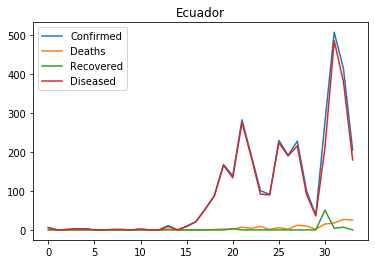

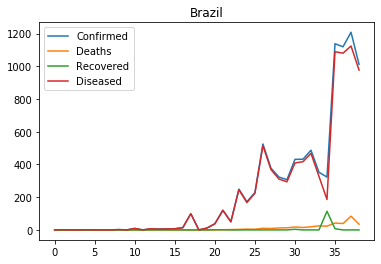

In [83]:
from src.country_analysis import CountryAnalysis
        
grouped = covid19Data.groupby(['Country/Region', 'ObservationDate']).sum().reset_index()
countries = pd.unique(grouped['Country/Region'])
data = dict()
for name in countries:
    covid19CurrentCountry = grouped[grouped['Country/Region'] == name]
    currentAnalysis = CountryAnalysis(name, covid19CurrentCountry)
    data[name] = currentAnalysis
data['Chile'].computeRelativeDistribution().plot(title='Chile')
data['Spain'].computeRelativeDistribution().plot(title='Spain')
data['US'].computeRelativeDistribution().plot(title='US')
data['Italy'].computeRelativeDistribution().plot(title='Italy')
data['Mainland China'].computeRelativeDistribution().plot(title='Mainland China')
data['Ecuador'].computeRelativeDistribution().plot(title='Ecuador')
data['Brazil'].computeRelativeDistribution().plot(title='Brazil')

Se muestra el grafico con datos acumulados para el caso de nuestro país

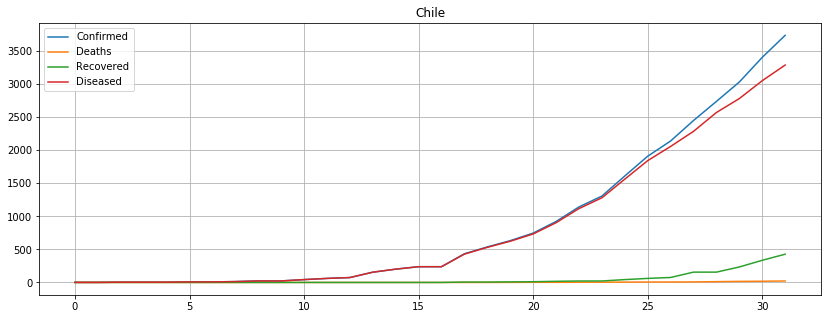

In [63]:
selectedCountry = 'Chile'
figsize = (14, 5)
nbins = 20
data[selectedCountry].computeRelativeDistribution().cumsum().plot(title=selectedCountry, figsize=figsize, grid=True)

### Análisis del comportamiento de los contagios
El gráfico a continuación muestra la dispersión de los casos confirmados en países que, por simple inspección, tenían curvas de contagio similares a nuestro país

El archivo "dataset.csv" es generado a partir del covid19.csv a través del script preproceso.py (que se encuentra en el repositorio) donde se generó el nuevo dato "num_dia_desde_primer_caso" que indica el número del día desde el primer contagio para la regióno o país de ese registro.

Esto último permitió dejar los paises comparables sin importar la fecha del registro

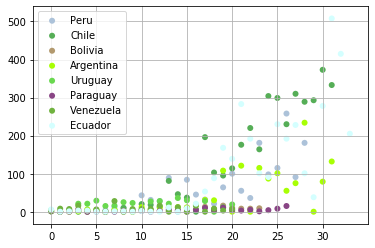

In [64]:
dset_base = pd.read_csv('dataset.csv',)
dset_extra = pd.read_csv('dataset_atributos_extra.csv')
dset = pd.merge(left=dset_base, right=dset_extra, how="inner")
colorlist = list(colors.ColorConverter.colors.keys())
paises = ["Peru","Chile","Bolivia","Argentina","Uruguay","Paraguay","Venezuela","Ecuador"]
dset_paises = dset[dset["pais"].isin(paises)]
fig, ax = plt.subplots()
counter = 0
for pais in paises :
    dset_pais = dset_base[dset_base["pais"]==pais]
    ax.scatter(dset_pais.num_dia_desde_primer_caso, dset_pais.num_confirmados, label=pais, edgecolors='none', color=colorlist[counter % len(colorlist)])
    counter+=1
ax.legend()
ax.grid(True)
plt.show()

Se experimenta, a partir del gráfico anterior, con una regresión polinomial de grado 3 (por simple inspección)

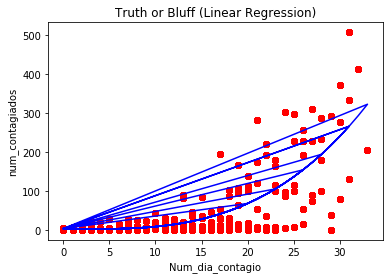

In [65]:
X = dset_paises.iloc[:,0:1].values
y = dset_paises.iloc[:,3].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)

# Visualizing the Polymonial Regression results
def viz_polymonial():
    plt.scatter(X, y, color='red')
    plt.plot(X, pol_reg.predict(poly_reg.fit_transform(X)), color='blue')
    plt.title('Truth or Bluff (Linear Regression)')
    plt.xlabel('Num_dia_contagio')
    plt.ylabel('num_contagiados')
    plt.show()
    return
viz_polymonial()

A continuación, se hace un análisis de la variación de la cantidad de casos confirmados gracias a los gráficos "caja y bigote" (boxplot)

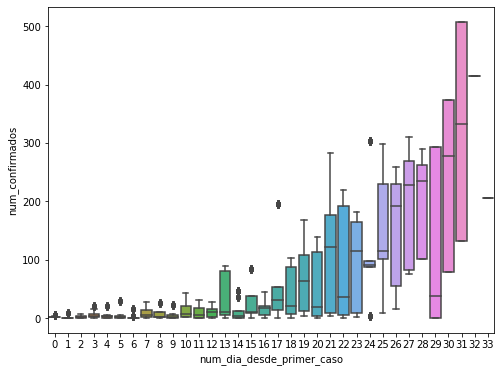

In [66]:
var = 'num_dia_desde_primer_caso'
data = pd.concat([dset_paises['num_confirmados'], dset_paises[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="num_confirmados", data=data)

Una de las hipótesis que había formulado el equipo era una posible correlación entre la cantidad de casos confirmados, por país, y alguno de los siguientes atributos:
 * Media de la edad de los habitantes del país
 * Producto interno bruto nominal per cápita del país, o su posición en el ranking mundial
 * El índice de desigualdad económica de la población (Gini)
 * La taza de mortalidad del país

Las hipótesis fueron descartadas, ya que, gracias a la matriz de calor de correlación, se puede ver que no existe afinidad (o reciprocidad) entre los datos mencionados

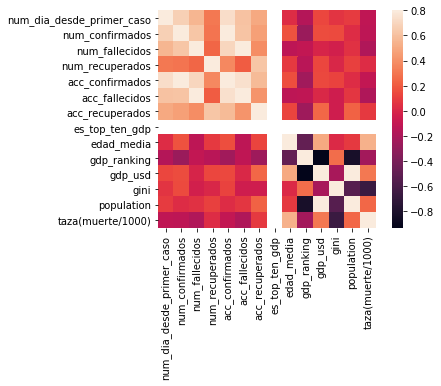

In [67]:
corrmat = dset_paises.corr()
f, ax = plt.subplots()
sns.heatmap(corrmat, vmax=.8, square=True);

Tampoco se lograron resultados positivos transformando la escala de los datos

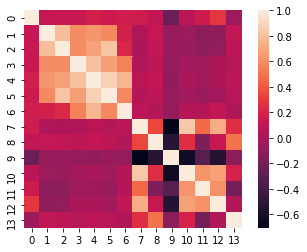

In [68]:
mm_scaler = preprocessing.MinMaxScaler()
dset_ = dset.drop("pais",axis=1)
dset_ = dset_.drop("region",axis=1)
nd_scaled_ds = mm_scaler.fit_transform(dset_)
scaled_ds = pd.DataFrame(nd_scaled_ds)
corrmat = scaled_ds.corr()
f, ax = plt.subplots()
sns.heatmap(corrmat, square=True);

Otra hipótesis descartada, fue la posible relación de las temperaturas con la cantidad de contagiados por país

Se descartó nuevamente gracias a la matriz de calor de correlación

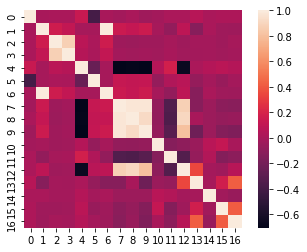

In [69]:
dset_weather = pd.read_csv('training_data_with_weather_info_week_4.csv',)
mm_scaler = preprocessing.MinMaxScaler()
dset_ = dset_weather.drop("Country_Region",axis=1)
dset_ = dset_.drop("Province_State",axis=1)
dset_ = dset_.drop("country+province",axis=1)
dset_['Date'] = pd.to_datetime(dset_['Date']).dt.dayofyear
dset_ = dset_.drop("ah",axis=1)
nd_scaled_ds = mm_scaler.fit_transform(dset_)
scaled_ds = pd.DataFrame(nd_scaled_ds)
corrmat = scaled_ds.corr()
f, ax = plt.subplots()
sns.heatmap(corrmat, square=True);

Retomando la idea de la regresión, es que se propuso intentar caracterizar los países (y una posible "clusterización") a través de los coeficientes de sus polinomios de la curva de la regresión

A continuación, la curva con los datos de nuestro país con un polinomio de grado 12

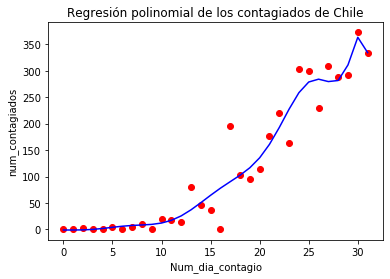

In [70]:
selected_pais = "Chile"
dset_pais = dset_base[dset_base["pais"]==selected_pais]
X = dset_pais.iloc[:,0:1].values
y = dset_pais.iloc[:,3].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=12)
X_poly = poly_reg.fit_transform(X)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)

# Visualizing the Polymonial Regression results
def viz_polymonial():
    plt.scatter(X, y, color='red')
    plt.plot(X, pol_reg.predict(poly_reg.fit_transform(X)), color='blue')
    plt.title('Regresión polinomial de los contagiados de Chile')
    plt.xlabel('Num_dia_contagio')
    plt.ylabel('num_contagiados')
    plt.show()
    return
viz_polymonial()

Se procedió a la extracción de características para cada país y un análisis rápido de posibilidad de agrupación gracias a la incrustación estocástica de vecinos (TSNE) 

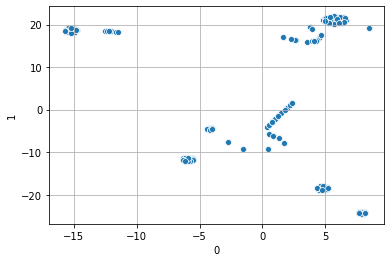

In [71]:
from sklearn.preprocessing import PolynomialFeatures

degree = 6
def ajuste_polinomial(X, y):
    """
    X es el dia que ha transcurrido desde el primer contagio
    y es el numero de contagiados, fallecidos y/o recuperados
    """
    poly_reg = PolynomialFeatures(degree=degree)
    X_poly = poly_reg.fit_transform(X)
    features = pd.Series(poly_reg.transform(X)[-1])
    # print(features)
    return features

features_df = dset_base.groupby(['region', 'pais']).apply(lambda x: ajuste_polinomial(x.iloc[:,0:1].values, x['num_confirmados'].values)).reset_index()
from sklearn.manifold import TSNE
features = features_df.select_dtypes('float64')
X_embedded = TSNE(n_components=2).fit_transform(features)
X_embedded = pd.DataFrame(X_embedded)
ax_tsne = sns.scatterplot(x=0, y=1, data = pd.DataFrame(X_embedded))
ax_tsne.grid(True)

Ante los resultados esperanzadores, se procedió a calcular clusters usando los algoritmos KMeans, aglomerativo y DBSCAN

DBSCAN:

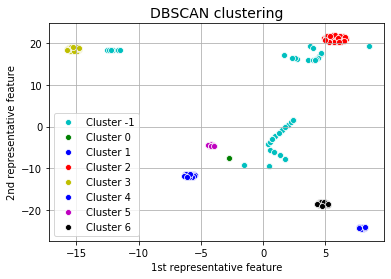

In [72]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
n_cluster = 3
kmeans_clusters = KMeans(n_clusters=n_cluster).fit_predict(features)
agglomerative_clusters = AgglomerativeClustering().fit_predict(features)
dbscan_clusters = DBSCAN(eps=0.3, min_samples=10).fit_predict(features)
color_map = {
    -1: 'c',
    0: 'g',
    1: 'b',
    2: 'r',
    3: 'y',
    4: 'b',
    5: 'm',
    6: 'k'
}

def plot_clustering(clusters, name=''):

    for cluster in np.unique(clusters):
        #print('Cluster {} has {} country/region'.format(cluster, features_df[clusters == cluster][['pais', 'region']].shape[0]))
        ax = sns.scatterplot(x=0, y=1, data = X_embedded[clusters == cluster], color =color_map[cluster], label='Cluster '+str(cluster))

    ax.grid(True)
    ax.set_title(name+' clustering', fontsize=14)
    ax.set_xlabel('1st representative feature')
    ax.set_ylabel('2nd representative feature')
    return ax

plot_clustering(dbscan_clusters, name='DBSCAN')

KMeans:

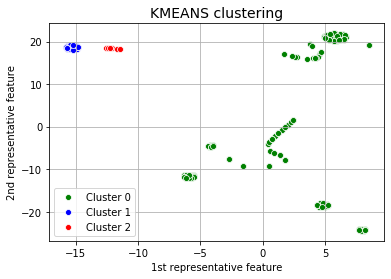

In [73]:
plot_clustering(kmeans_clusters, name='KMEANS')

Agglomerative Clustering:

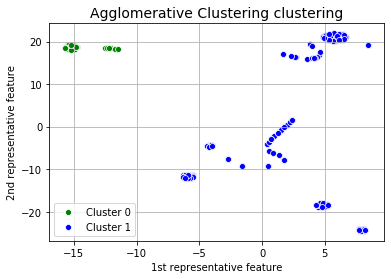

In [74]:
plot_clustering(agglomerative_clusters, name='Agglomerative Clustering')

Queda como trabajo futuro estudiar en profundidad las diferencias de los países o regiones dentro de cada cluster, y las diferencias de los resultados de cada algoritmo. Además, quedará pendiente propuestas de proyecciones que nos permitan estimar cuando el virus estaría bajo control en nuestro país